# Dataset preparation

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from tqdm import tqdm

# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256),#, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        #transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standard
    ]),
    # Validation does not use augmentation
    'valid':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [2]:
from torchvision import datasets
from torch.utils.data import DataLoader, Subset
import numpy as np
batch_size = 64
# Datasets from folders
train_dataset = datasets.ImageFolder(root='Images', transform=image_transforms['train'])
valid_dataset = datasets.ImageFolder(root='Images', transform=image_transforms['valid'])

total_len = len(train_dataset)
train_size = 0.8
valid_size = 0.1
test_size = 0.1
indices = list(range(total_len))
np.random.shuffle(indices)
# Dataloader iterators, make sure to shuffle
train_data = Subset(train_dataset,indices=indices[:int(np.floor(train_size*total_len))])
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_data = Subset(valid_dataset ,indices=indices[int(np.floor((train_size-1)*total_len)):int(np.floor(-valid_size*total_len))])
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_data = Subset(valid_dataset ,indices=indices[int(np.floor((train_size+valid_size-1)*total_len)):])
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)




## Testing if images are loaded correctly

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'n02091831-Saluki')

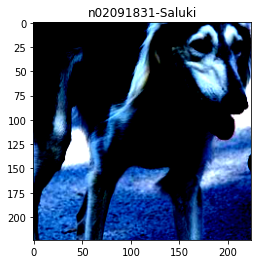

In [3]:
import matplotlib.pyplot as plt
import numpy as np
images, labels = next(iter(valid_dataloader)) 
im = images[0].numpy().transpose((1,2,0))
plt.imshow(im)
plt.title(valid_dataset.classes[labels[0]])


# Model creation

In [4]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running model on:",device)

Running model on: cuda:0


In [5]:
model = torchvision.models.resnet50(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Freeze model weights

In [6]:
for param in model.parameters():
    param.requires_grad = False

## loss and optimizer

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

## Trainig

In [8]:
def train(n_epochs=5):
    for epoch in tqdm(range(n_epochs)):
        #train_loss = []
        for data_t, targets_t in train_dataloader:
            data_t = data_t.to(device)
            targets_t = targets_t.to(device)
            optimizer.zero_grad()
            # Generate predictions
            out = model(data_t)
            # Calculate loss
            loss = criterion(out, targets_t)
            #train_loss.append(loss.item())
            # Backpropagation
            loss.backward()
            # Update model parameters
            optimizer.step()
        #print("Loss: ",np.average(train_loss))

## Validation

In [9]:
def test(dataloader=test_dataloader):
    val_loss = []
    val_acc = []
    batch_loss = 0
    correct_t = 0
    total_t = 0
    with torch.no_grad():
            model.eval()
            for data_t, target_t in (dataloader):
                data_t, target_t = data_t.to(device), target_t.to(device)
                out = model(data_t)
                loss = criterion(out, target_t)

                _,pred_t = torch.max(out, dim=1)
                correct_t += torch.sum(pred_t==target_t).item()
                total_t += target_t.size(0)
            acc = 100 * correct_t/total_t
            val_acc.append(acc)
            val_loss.append(loss.item())
            print(f'Loss: {np.mean(val_loss):.4f}, accuracy: {(acc):.4f}%\n')

# Replace last fully connected layer

In [10]:
model.fc = nn.Linear(in_features=2048, out_features=120,bias=True)



# Update loss and optimizer for new model

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
model.to(device)
print()

In [12]:
train(10)
test(valid_dataloader)

100%|██████████| 10/10 [08:58<00:00, 53.83s/it]
Loss: 0.8281, accuracy: 84.6453%



# Unfreeeze last conv layer

In [13]:

for param in model.layer4.parameters():
    param.requires_grad = True

In [14]:
train(10)
test(valid_dataloader)

100%|██████████| 10/10 [08:23<00:00, 50.35s/it]
Loss: 0.8744, accuracy: 85.6657%



# Unfreeeze second-to-last conv layer

In [15]:
for param in model.layer3.parameters():
    param.requires_grad = True

In [16]:
train(10)
test(valid_dataloader)

100%|██████████| 10/10 [14:57<00:00, 89.76s/it]
Loss: 0.6653, accuracy: 85.4227%



# Testing on unseen data

In [17]:
test(test_dataloader)

Loss: 2.0332, accuracy: 85.5199%



# Untrained model

In [18]:
model = torchvision.models.resnet50(pretrained=False)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
model.to(device)
print()

In [19]:
train(5)
test(valid_dataloader)

100%|██████████| 5/5 [16:55<00:00, 203.00s/it]
Loss: 4.6742, accuracy: 8.0175%

